![](https://miro.medium.com/v2/resize:fit:828/format:webp/1*vyXO4v0OQsmcctUcx6jL3w.png?)

# Table of Contents
- [1. Introduction](#Intro)
- [2. Data Understanding and Data Prepartion](#Pre)
    - [2.1 Data Understanding](#data-understanding)        
    - [2.2 Data Preparation](#data-preparation)  
        - [2.2.1 Missing Value Insepction](#missing-value)
        - [2.2.2 Feature Engineering](#FE)
        - [2.2.3 Exploratory Data Analysis](#eda)  
        - [2.2.4 Feature Selection](#fs)
- [3. Data Modeling](#dm)
    - [3.1 Hyperparameter tuning](#Hyper) 
    - [3.2 Model Interpretation](#Inter) 
- [4. Conclusions](#conclusion)





<a id="Intro"></a>
# 1. Introduction
[Sparkify]((https://www.kaggle.com/datasets/kuixizhu/sparkify-small-log) is a ficitonal music streaming platform with a vast user base engaging with the service daily. Similar to leading platforms such as Spotify and Pandora, users have the option to utilize a free account, which features intermittent advertisements between songs, or to upgrade to a premium account offering ad-free listening and enhanced sound quality for a monthly fee. Given that revenue from premium accounts significantly contributes to the company's overall income, our objective is to develop a classifier capable of identifying potential churn customers. Additionally, we aimed to uncover actionable insights that could inform strategic business decisions, ultimately safeguarding millions in revenue for the company.

<a id="Pre"></a>
# 2. Data Understanding and Data Prepartion


<a id="data-understanding"></a>
## 2.1 Data Understanding


In [ ]:
!pip install pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pyspark.sql.types import DoubleType
import math
from pyspark.sql.functions import *
from scipy import stats
from statsmodels.stats.multitest import multipletests
from pyspark.ml.feature import StandardScaler,MinMaxScaler
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,GBTClassifier,LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import PCA


pd.options.display.max_columns = None
pd.options.display.max_rows = None

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=cd9a2d75b9e14f4b4965a90f00d88880047c6934da52694846ad42857ac992ca
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession

## Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

## Read in small sparkify dataset for EDA
#event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
event_data = "/kaggle/input/sparkify-small-log/mini_sparkify_event_data.json"
user_log_small = spark.read.json(event_data)
user_log_small.printSchema()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/04 20:04:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Since there is no document explaining the meaning of each feature, I will take a look at the data and get a sense of the data.

In [ ]:
user_log_small.toPandas().head(3)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


For the features, they can be divided into 3 categories: user features, song features and user-platform interaction features.



**User Feature**

| Feature    | DataType | Description |
| --- | --- | ---|
|userId|string|user identifier|
|firstName|string|user’s first name|
|lastName|string|user’s last name|
|gender|string(categorical)|user’s gender (M and F)|
|registration|long|user’s registration timestamp|
|level|string(categorical)|subscription level (free and paid)|
|location|string|user’s location|


**Song Feature**

| Feature    | DataType | Description |
| --- | --- | ---|
|song|string|song name|
|artist|string|artist name|
|length|double|song’s length in seconds|

**User-platform Interaction Feature**

| Feature    | DataType | Description |
| --- | ---| ---|
|auth|string(categorical)|authentication level (Logged In, Logged Out, Cancelled, Guest)|
|itemInSession|long|log count in a given session|
|method|string(categorical)|http request method (GET and PUT)|
|page|string(categorical)|type of interaction (NextSong, Home, **Cancellation Confirmation**, etc.)|
|sessionId|long|session to which the log belongs to|
|status|long(categorical)|http status code (200, 307 and 404)|
|ts|long|timestamp of a given log|
|userAgent|string|agent used by the user to access the streaming service|


In the page varaible, **Cancellation Confirmation** is an indicator of customer churn.

<a id="data-preparation"></a>
## 2.2 Data Preparation


Before we conduct any exploration data analysis (EDA), we need to do some data wrangling to proprocess the data.

<a id="missing-value"></a>
### 2.2.1 Missing Value Insepection

In [ ]:
from pyspark.sql.functions import isnan, when, count, col,round,asc,desc
nrow = user_log_small.count()
user_log_small.select([round(100*count(when(col(c).isNull(), c))/nrow,2).alias(c) for c in user_log_small.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 20.38| 0.0|     2.91|  2.91|          0.0|    2.91| 20.38|  0.0|    2.91|   0.0| 0.0|        2.91|      0.0|20.38|   0.0|0.0|     2.91|   0.0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+




There are two distinct categories of missing values within the dataset, each pertaining to different aspects of the data:

Song-Related Features: This group comprises attributes directly associated with songs, such as artist, song length, and song title. The proportion of missing values within this category amounts to 20.38% of the entire dataset.

User-Related Features: In contrast, this group encompasses attributes relevant to user profiles, including first name, gender, last name, location, registration, and user agent. The percentage of missing values within this set of features is notably lower, accounting for 2.91% of the dataset.

In [ ]:
user_log_small = user_log_small.withColumn('song_na',col('song').isNull())
user_log_small = user_log_small.withColumn('user_na',col('firstName').isNull())

In [ ]:
user_log_small.groupBy('song_na','page').count().orderBy(desc('count')).show()

+-------+--------------------+------+
|song_na|                page| count|
+-------+--------------------+------+
|  false|            NextSong|228108|
|   true|                Home| 14457|
|   true|           Thumbs Up| 12551|
|   true|     Add to Playlist|  6526|
|   true|          Add Friend|  4277|
|   true|         Roll Advert|  3933|
|   true|               Login|  3241|
|   true|              Logout|  3226|
|   true|         Thumbs Down|  2546|
|   true|           Downgrade|  2055|
|   true|                Help|  1726|
|   true|            Settings|  1514|
|   true|               About|   924|
|   true|             Upgrade|   499|
|   true|       Save Settings|   310|
|   true|               Error|   258|
|   true|      Submit Upgrade|   159|
|   true|    Submit Downgrade|    63|
|   true|Cancellation Conf...|    52|
|   true|              Cancel|    52|
+-------+--------------------+------+
only showing top 20 rows



In [ ]:
user_log_small.groupBy('user_na','auth').count().orderBy(desc('count')).show()

+-------+----------+------+
|user_na|      auth| count|
+-------+----------+------+
|  false| Logged In|278102|
|   true|Logged Out|  8249|
|   true|     Guest|    97|
|  false| Cancelled|    52|
+-------+----------+------+



After comparing the distribution of page and auth in samples with and without missing values, we found that:
1. Song related features are missing in samples where the page equals to **NextSong**.
2. Users realted features are missing in samples where the auth values are **Logged Out** and **Guest**.

Both of these observation makes perfect sense. As we are going to build a classifier on user level, we only need to remove samples containing NULL value in user related features.

In [ ]:
user_log_small = user_log_small.na.drop(subset=['firstName'])

<a id="FE"></a>
### 2.2.2 Feature Engineering

#### Define Churn User
Here, for each user,  I would definite the user as churn user if **Cancellation Confirmation** ever appear in the user's **page** column.

In [ ]:
# Generate churn feature
user_log_small.createOrReplaceTempView('user_log_small_table')

user_churn = spark.sql('''
        SELECT userId,
               MAX(IF(page = "Cancellation Confirmation",1,0)) as churn
        FROM user_log_small_table
        GROUP BY userId
''')





Let's start with the user related features.

#### User Feature

| Feature    | DataType | Description |
| --- | --- | ---|
|userId|string|user identifier|
|firstName|string|user’s first name|
|lastName|string|user’s last name|
|gender|string(categorical)|user’s gender (M and F)|
|registration|long|user’s registration timestamp|
|level|string(categorical)|subscription level (free and paid)|
|location|string|user’s location|


I choose gender, level, location and registration as they are informative features.  

**gender**  
- ***gender_cate***: Binary encoding 'M' and 'F' into 1 and 0 for gender representation.


**registraiton**  
- ******registration_duration_day***: The length of time since user's registration (unit: days).

**level**

For the "level" feature, it presents an intriguing insight into user behavior, particularly considering the dynamic nature where users can freely switch between free and paid statuses at any point. Specifically, the following aspects are of interest for each user:


1. **Frequency of Transition**: This denotes the number of times a user switches from free to paid status, reflecting their decision-making patterns.

2. **Reversion Frequency**: Indicates the number of times a user reverts from paid to free status, shedding light on potential dissatisfaction or preference changes.

3. **Average Duration in Free Status**: This metric calculates the average duration a user's account remains in the free level, offering insights into user engagement and retention in the free tier.

4. **Average Duration in Paid Status**: Similarly, this measure computes the average duration a user's account stays in the paid level, revealing patterns of user commitment and investment in premium services.

5. **The User's Latest Account Level**: It is the user's latest account status (free/paid).

6. **Time Since Registration to First Interaction**: This duration reflects the engagement level of users with the platform, capturing their immediacy in utilizing platform features post-registration.

Correspondingly, I will generate these feaures:
- ***free_to_paid***: The number of transitions from free to paid level
- ***paid_to_free***: The number of transitions from paid to free level
- ***level_free_avg_duration_day***: The average duration of time the user account remains in the free level (unit: days)
- ***level_paid_avg_duration_day***: The average duration of time the user account remains in the paid level (unit: days)
- ***last_level***:  The user's lastest account level.last_level - The user's lastest account level.
- ***duration_beforeFirstAction***: The  Duration of time between user registration and the first platform interaction (unit: days)

**location**

Here I will extract the state name and map it to [state-level average household income in the United States](https://www2.census.gov/programs-surveys/cps/tables/time-series/historical-income-households/h08.xls). This new feature would provide insights into regional socioeconomic status.

- ***location_income***: The average house-hold income of the location




In [ ]:
# Generate features related to user gender:
# Feature 1: gender_cate - Mapping gender values: 'M' to 1, 'F' to 0.


user_gender = spark.sql(
    '''
    SELECT userId,
           SUBSTRING_INDEX(ANY_VALUE(location),', ',-1) as location,
           ANY_VALUE(gender) as gender,
           IF(ANY_VALUE(gender)='M',1,0) as gender_code
    FROM user_log_small_table
    GROUP BY userId
    '''
)


In [ ]:
# Generate features related to user registration:
# Feature 1: registration_duration_day - The length of time since user's registration (unit: days).

user_duration = spark.sql('''
    SELECT  userID,
            ROUND((MAX(ts) - MAX(registration))/(1000*3600*24),2) as registration_duration_day
    FROM user_log_small_table
    GROUP BY userId
''')


In [ ]:
# Generate features related to user account level transitions and durations:
# Feature 1: free_to_paid - Number of transitions from free to paid level
# Feature 2: paid_to_free - Number of transitions from paid to free level
# Feature 3: level_free_avg_duration_day - Average duration of time the user account remains in the free level (unit: days)
# Feature 4: level_paid_avg_duration_day - Average duration of time the user account remains in the paid level (unit: days)
# Feature 5: last_level - The user's lastest account level.
# Feature 6: duration_beforeFirstAction - Duration of time between user registration and the first platform interaction (unit: days)

user_level_switch = spark.sql('''
    WITH CTE AS(
        SELECT userId,
               IF(level='paid' and LAG(level) over w='free',1,0) AS free_to_paid,
               IF(level='free' and LAG(level) over w='paid',1,0) AS paid_to_free ,
               IF(LAST(level) over w='paid',1,0) as last_level
        FROM user_log_small_table
        WINDOW w as (PARTITION BY userId ORDER BY ts)
    )

    SELECT userId,
           SUM(free_to_paid) as level_free_to_paid,
           SUM(paid_to_free) as level_paid_to_free,
           ANY_VALUE(last_level) as last_level
    FROM CTE
    GROUP BY userId
''')


user_level_duration = spark.sql('''
    WITH CTE AS(
        SELECT userId,
               IF(level != LAG(level) over w,1,0) AS change_flag,
               level,
               ts,
               registration
        FROM user_log_small_table
        WINDOW w as (PARTITION BY userId ORDER BY ts)
    ),

    CTE_phase AS(
        SELECT userId,
               SUM(change_flag) over w as phase,
               level,
               ts,
               registration
        FROM CTE
        WINDOW w as (PARTITION BY userId ORDER BY ts ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW)
    ),

    CTE_phase_duration AS(
        SELECT userId,
               level,
               CASE WHEN phase > 0 THEN ROUND((MAX(ts) - MIN(ts))/(1000*3600*24),2)
                    WHEN phase = 0 THEN ROUND((MAX(ts) - ANY_VALUE(registration))/(1000*3600*24),2)
                    END as duration_day ,
               IF(phase = 0,ROUND((MIN(ts) - ANY_VALUE(registration))/(1000*3600*24),2),0) as duration_beforeFirstAction
        FROM CTE_phase
        GROUP BY userId,level,phase
    ),

    RESULT AS(
        SELECT userId,
               level,
               COUNT(*) as phase_cnt,
               ROUND(AVG(duration_day),2) as level_avg_duration_day ,
               SUM(duration_beforeFirstAction) as duration_beforeFirstAction
        FROM CTE_phase_duration
        GROUP BY userId,level
    )

    SELECT userId,
           MAX(IF(level="free",phase_cnt,0)) as free_cnt,
           MAX(IF(level="paid",phase_cnt,0)) as paid_cnt,
           MAX(IF(level="free",level_avg_duration_day,0)) as level_free_avg_duration_day,
           MAX(IF(level="paid",level_avg_duration_day,0)) as level_paid_avg_duration_day,
           MAX(duration_beforeFirstAction) as duration_beforeFirstAction
    FROM RESULT
    GROUP BY userId

''')

In [ ]:
# Genreate feature for location
# Feature 1: location_income - The average house-hold income of the location

spark_state = spark.read.csv("s3://spark-udacity-joo/states.csv", header=True)
spark_state.createOrReplaceTempView('state_table')
getLocation = udf(lambda x:x.split(", ")[-1])

user_log_small = user_log_small.withColumn('location',getLocation(user_log_small.location))
user_log_small.createOrReplaceTempView('user_log_small_table')


location_income = spark.sql('''
    WITH log_state AS(
        SELECT DISTINCT SUBSTRING_INDEX(LOCATION,', ',-1) as state_abb
        FROM user_log_small_table
    ),

    State_Income AS (
        SELECT Abbreviation,
               DOUBLE(REPLACE(Income,",","")) as Income
        FROM  state_table
    )

    SELECT state_abb as location,
           AVG(Income) location_income
    FROM log_state
         JOIN State_Income ON state_abb = Abbreviation
                           OR SUBSTRING_INDEX(SUBSTRING_INDEX(state_abb,'-',1),'-',-1) = Abbreviation
                           OR SUBSTRING_INDEX(SUBSTRING_INDEX(state_abb,'-',2),'-',-1) = Abbreviation
                           OR SUBSTRING_INDEX(SUBSTRING_INDEX(state_abb,'-',3),'-',-1) = Abbreviation
                           OR SUBSTRING_INDEX(SUBSTRING_INDEX(state_abb,'-',4),'-',-1) = Abbreviation
    GROUP BY state_abb
    '''
)

Put the new features together and normalize the time-duration realted features.

In [ ]:

data_user = user_churn.join(user_gender,on='userId') \
                  .join(user_duration,on='userId') \
                  .join(user_level_switch,on='userId') \
                  .join(user_level_duration,on='userId') \
                  .join(location_income,on='location')

data_user = data_user.withColumn('level_free_avg_duration_ratio',(data_user.level_free_avg_duration_day) /  (data_user.registration_duration_day))
data_user = data_user.withColumn('level_paid_avg_duration_ratio',data_user.level_paid_avg_duration_day /  data_user.registration_duration_day)
data_user = data_user.withColumn('level_free_duration_ratio',data_user.level_free_avg_duration_day * data_user.free_cnt /  data_user.registration_duration_day)
data_user = data_user.withColumn('level_paid_duration_ratio',data_user.level_paid_avg_duration_day * data_user.paid_cnt /  data_user.registration_duration_day)


#### Song Feature

| Feature    | DataType | Description |
| --- | --- | ---|
|song|string|song name|
|artist|string|artist name|
|length|double|song’s length in seconds|

In this part, I aim to understand users' behavior patterns, particularly focusing on their song listening habits, including the variety of songs they listen to, whether they listen to full tracks or just parts, and their interaction patterns with the platform. By examining user actions throughout their time on the platform, I seek to uncover insights such as whether users engage with the platform immediately after registration or if they maintain regular interaction over time.

Here I will create these features:  
- ***song_cnt***: The number of song listened by user
- ***distinct_song_cnt***: The number of unique song listened by user
- ***song_entropy***: The entropy of the probability distribution of played songs by user
- ***artist_entropy***:  The entropy of the probability distribution of the artists of played songs by user
- ***song_percent_avg***: The mean value of percentage of a song listened by user.
- ***song_percent_std***: The standard deviation value of percentage of a song listened by user.

- ***action_ts_avg***: The average timing of user actions.
- ***action_ts_std***: The variability in the timing of user actions.
                          
- ***action_hist_0 ~ action_hist_9*** : Represents the distribution of timestamp of user actions.                                            Each feature (action_hist_i) corresponds to a bin in the histogram of normalized timestamps.
The values represent the frequency of user actions falling into each bin.

In [ ]:
user_log_small.createOrReplaceTempView('user_log_small_table')

# Genreate feature for song
# Feature 1: song_cnt - The number of song listened by user
# Feature 2: distinct_song_cnt - The number of unique song listened by user

song_cnt = spark.sql('''
    SELECT userId,
           COUNT(song) as song_cnt,
           COUNT(DISTINCT song) as distinct_song_cnt
    FROM user_log_small_table
    WHERE song IS NOT NULL
    GROUP BY userId

''')

In [ ]:
# Genreate feature for song
# Feature 1: song_entropy - The entropy of the probability distribution of played songs by user
# Feature 2: artist_entropy - The entropy of the probability distribution of the artists of played songs by user

def entropy(probabilities):
  """Computes entropy of a list of probabilities.

  Args:
    probabilities: A list of probabilities.

  Returns:
    The entropy of the list of probabilities.
  """

  entropy = 0.0

  for probability in probabilities:
    entropy -= probability * math.log2(probability)
  return entropy


entropy_udf = udf(entropy, DoubleType())


song_proba = spark.sql('''
    WITH CTE AS(
        SELECT userId,
               song,
               COUNT(*) as song_cnt
        FROM user_log_small_table
        WHERE song IS NOT NULL
        GROUP BY userId,song
    ),

    total_table AS(
        SELECT userId,
               COUNT(*) as total_song_cnt
        FROM user_log_small_table
        WHERE song IS NOT NULL
        GROUP BY userId
    )

    SELECT userId,
           song,
           song_cnt / total_song_cnt as proba
    FROM CTE
         JOIN total_table USING(userId)

''')

artist_proba = spark.sql('''
    WITH CTE AS(
        SELECT userId,
               artist,
               COUNT(*) as artist_cnt
        FROM user_log_small_table
        WHERE artist IS NOT NULL
        GROUP BY userId,artist
    ),

    total_table AS(
        SELECT userId,
               COUNT(*) as total_artist_cnt
        FROM user_log_small_table
        WHERE artist IS NOT NULL
        GROUP BY userId
    )

    SELECT userId,
           artist,
           artist_cnt / total_artist_cnt as proba
    FROM CTE
         JOIN total_table USING(userId)
''')


# Generate song and artist entropy feature
song_entropy = song_proba.groupBy('userId').agg(entropy_udf(collect_list('proba')).alias('song_entropy'))
artist_entropy = artist_proba.groupBy('userId').agg(entropy_udf(collect_list('proba')).alias('artist_entropy'))


In [ ]:
# Genreate feature for song listening behavior
# Feature 1: song_percent_avg - The mean value of percentage of a song listened by user.
# Feature 2: song_percent_std - The standard deviation value of percentage of a song listened by user.

song_percent = spark.sql('''
        WITH CTE AS(
            SELECT userId,
                   CASE WHEN ROUND(100*((LEAD(ts) over w ) - ts) /(1000*length),2) > 100 THEN 100
                        ELSE ROUND(100*((LEAD(ts) over w ) - ts) /(1000*length),2)
                   END as song_percentage
            FROM user_log_small_table
            WINDOW w as (PARTITION BY userId, sessionId ORDER BY ts)
        )

        SELECT userId,
               AVG(song_percentage) as song_percent_avg,
               STD(song_percentage) as song_percent_std
        FROM CTE
        GROUP BY userId
    '''
)


In [ ]:
# Genreate feature for the timestamp of user's action
# Feature 1: action_ts_avg - Represents the average timing of user actions,
#                            It is computed as the mean value of the user action's normalized timestamps.
# Feature 2: action_ts_std - Represents the variability in the timing of user actions.
#                            It is computed as the standard deviation of the user action's normalized timestamps.
# Feature 3: action_hist_0 to action_hist_9 - Represents the distribution of timestamp of user actions.
#                                            Each feature (action_hist_i) corresponds to a bin in the histogram of normalized timestamps.
#                                            The values represent the frequency of user actions falling into each bin.
#All metrics are based on the normalized value between 0 and 1 according to the lifespan of the user account.

action_ts = spark.sql('''
        SELECT userId,
               (ts -  (MIN(registration) over w)) / ((MAX(ts) over w) - (MIN(registration) over w)) as ts_percent
        FROM user_log_small_table
        WINDOW w as (PARTITION BY userId)
    '''
)

# Define a function to calculate histogram bins with probabilities
def calculate_histogram_bins_prob(timestamps):
    # Calculate bin size
    bin_size = 0.1
    # Initialize bins
    n = len(timestamps)
    bins = [0.0]*10
    # Iterate over timestamps and increment bin counts
    for ts in timestamps:
        index = int(ts  // bin_size)
        if index>=10:
            index = 9
        elif index < 0 :
            index = 0
        bins[index] += 1/n

    return bins


# Register the UDF
histogram_bins_prob_udf = udf(calculate_histogram_bins_prob, ArrayType(DoubleType()))

# Apply the UDF to calculate histogram bins with probabilities for each user
action_distribution = action_ts.groupBy("userId").agg(histogram_bins_prob_udf(collect_list('ts_percent')).alias("histogram_bins_prob"),
                                                      mean('ts_percent').alias('action_ts_avg'),
                                                      stddev('ts_percent').alias('action_ts_std')
                                                     )

# Split list into columns
action_distribution = action_distribution.select("userId",
                           action_distribution.histogram_bins_prob[0].alias('action_hist_0'),
                           action_distribution.histogram_bins_prob[1].alias('action_hist_1'),
                           action_distribution.histogram_bins_prob[2].alias('action_hist_2'),
                           action_distribution.histogram_bins_prob[3].alias('action_hist_3'),
                           action_distribution.histogram_bins_prob[4].alias('action_hist_4'),
                           action_distribution.histogram_bins_prob[5].alias('action_hist_5'),
                           action_distribution.histogram_bins_prob[6].alias('action_hist_6'),
                           action_distribution.histogram_bins_prob[7].alias('action_hist_7'),
                           action_distribution.histogram_bins_prob[8].alias('action_hist_8'),
                           action_distribution.histogram_bins_prob[9].alias('action_hist_9'),
                           "action_ts_avg","action_ts_std"
                          )

Putting these new features into the original table

In [ ]:
data_action = song_cnt.join(song_entropy,on='userId') \
              .join(artist_entropy,on='userId') \
              .join(song_percent,on='userId') \
              .join(action_distribution,on='userId')

#### User-platform Interaction Feature

| Feature    | DataType | Description |
| --- | ---| ---|
|auth|string(categorical)|authentication level (Logged In, Logged Out, Cancelled, Guest)|
|itemInSession|long|log count in a given session|
|method|string(categorical)|http request method (GET and PUT)|
|page|string(categorical)|type of interaction (NextSong, Home, **Cancellation Confirmation**, etc.)|
|sessionId|long|session to which the log belongs to|
|status|long(categorical)|http status code (200, 307 and 404)|
|ts|long|timestamp of a given log|
|userAgent|string|agent used by the user to access the streaming service|


In this section, I'm concentrating on the page and ts features. ***Page*** represents a categorical feature describing users' actions, encompassing activities like thumbs down, thumbs up, visiting the home page, requesting account upgrades, and more. I'll be quantifying the frequency of each action occurrence, which will subsequently be normalized by the lifespan of each customer.

As for ***ts***, I'll be computing the average duration of each session.

In [ ]:
inter_page = spark.sql('''
    SELECT UserId,
           SUM(IF(page="Submit Downgrade",1,0)) as cnt_page_submitDowngrade,
           SUM(IF(page="Thumbs Down",1,0)) as cnt_page_ThumbsDown,
           SUM(IF(page="Home",1,0)) as cnt_page_Home,
           SUM(IF(page="Downgrade",1,0)) as cnt_page_Downgrade,
           SUM(IF(page="Roll Advert",1,0)) as cnt_page_RollAdvert,
           SUM(IF(page="Logout",1,0)) as cnt_page_Logout,
           SUM(IF(page="Save Settings",1,0)) as cnt_page_SaveSettings,
           SUM(IF(page="About",1,0)) as cnt_page_About,
           SUM(IF(page="Settings",1,0)) as cnt_page_Settings,
           SUM(IF(page="Add to Playlist",1,0)) as cnt_page_AddtoPlaylist,
           SUM(IF(page="NextSong",1,0)) as cnt_page_NextSong,
           SUM(IF(page="Help",1,0)) as cnt_page_Help,
           SUM(IF(page="Upgrade",1,0)) as cnt_page_upgrade,
           SUM(IF(page="Error",1,0)) as cnt_page_Error,
           SUM(IF(page="Submit Upgrade",1,0)) as cnt_page_SubmitUpgrade
    FROM user_log_small_table
    GROUP BY userId
''')

In [ ]:
inter_session = spark.sql('''
    WITH CTE AS(
        SELECT userId,
               sessionId,
               (MAX(ts)-MIN(ts))/(1000*3600*24) as session_duration_day
        FROM user_log_small_table
        GROUP BY userId,sessionId
    )

    SELECT userId,
           COUNT(DISTINCT sessionId) session_cnt,
           AVG(session_duration_day) as avg_session_duration_day
    FROM CTE
    GROUP BY userId
''')

Put everything together

In [ ]:
data_inter = inter_page.join(inter_session,on='userId')
data_final = data_user.join(data_action,on='userId').join(data_inter,on='userId')

In [ ]:
data_final.printSchema()
data_final = data_final.withColumn("cnt_page_ThumbsDown",data_final.cnt_page_ThumbsDown/data_final.registration_duration_day) \
                       .withColumn("cnt_page_Home",data_final.cnt_page_Home/data_final.registration_duration_day) \
                       .withColumn("cnt_page_Downgrade",data_final.cnt_page_Downgrade/data_final.registration_duration_day) \
                       .withColumn("cnt_page_RollAdvert",data_final.cnt_page_RollAdvert/data_final.registration_duration_day) \
                       .withColumn("cnt_page_Logout",data_final.cnt_page_Logout/data_final.registration_duration_day) \
                       .withColumn("cnt_page_SaveSettings",data_final.cnt_page_SaveSettings/data_final.registration_duration_day) \
                       .withColumn("cnt_page_About",data_final.cnt_page_About/data_final.registration_duration_day) \
                       .withColumn("cnt_page_Settings",data_final.cnt_page_Settings/data_final.registration_duration_day) \
                       .withColumn("cnt_page_AddtoPlaylist",data_final.cnt_page_AddtoPlaylist/data_final.registration_duration_day) \
                       .withColumn("cnt_page_NextSong",data_final.cnt_page_NextSong/data_final.registration_duration_day) \
                       .withColumn("cnt_page_Help",data_final.cnt_page_Help/data_final.registration_duration_day) \
                       .withColumn("cnt_page_upgrade",data_final.cnt_page_upgrade/data_final.registration_duration_day) \
                       .withColumn("cnt_page_Error",data_final.cnt_page_Error/data_final.registration_duration_day) \
                       .withColumn("cnt_page_SubmitUpgrade",data_final.cnt_page_SubmitUpgrade/data_final.registration_duration_day)

# Discard unnecessary features and features encoded or normalized in other feature names
data_final = data_final.drop("userId","location","gender","level_free_avg_duration_day","level_paid_avg_duration_day")

root
 |-- userId: string (nullable = true)
 |-- location: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- gender_code: integer (nullable = false)
 |-- registration_duration_day: double (nullable = true)
 |-- level_free_to_paid: long (nullable = true)
 |-- level_paid_to_free: long (nullable = true)
 |-- last_level: integer (nullable = true)
 |-- free_cnt: long (nullable = true)
 |-- paid_cnt: long (nullable = true)
 |-- level_free_avg_duration_day: double (nullable = true)
 |-- level_paid_avg_duration_day: double (nullable = true)
 |-- duration_beforeFirstAction: double (nullable = true)
 |-- location_income: double (nullable = true)
 |-- level_free_avg_duration_ratio: double (nullable = true)
 |-- level_paid_avg_duration_ratio: double (nullable = true)
 |-- level_free_duration_ratio: double (nullable = true)
 |-- level_paid_duration_ratio: double (nullable = true)
 |-- song_cnt: long (nullable = false)
 |-- distinct_song_cnt: lo

<a id="eda"></a>
### 2.2.3 Exploratory Data Analysis

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

vec_col = 'corr_features'
# assemble all vector columns into one vector column
assembler = VectorAssembler(inputCols=data_final.columns, outputCol=vec_col)
corr_df = assembler.transform(data_final).select(vec_col)

# compute the correlation between 'churn' and every feature and the correlation between each pair of features
corr_mat = Correlation.corr(corr_df, vec_col)
# convert the corrlation matrix to a pandas dataframe with column names
corr_values = corr_mat.collect()[0][0].values
corr_mat_pd = pd.DataFrame(corr_values.reshape(-1, len(data_final.columns)), \
                           index=data_final.columns, columns=data_final.columns)

24/03/04 20:07:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Draw the correlation among features

<Axes: >

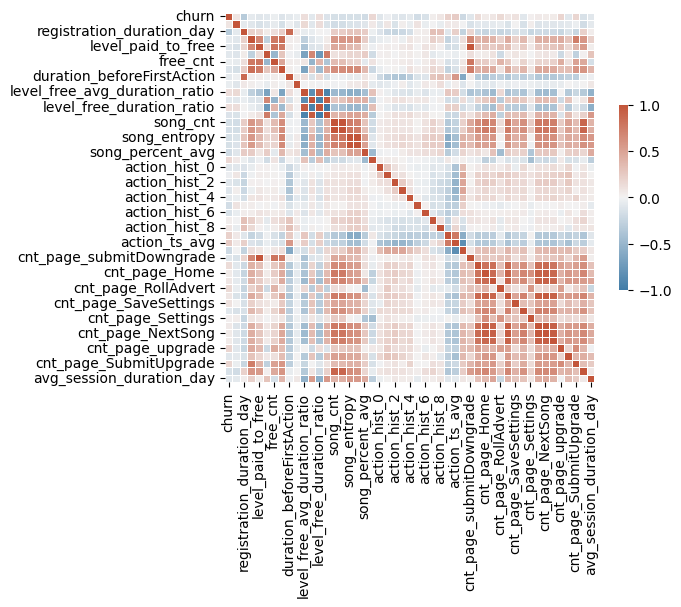

In [ ]:
# plot feature correlations
sns.heatmap(corr_mat_pd, vmin=-1, vmax=1, cmap=sns.diverging_palette(240, 20, as_cmap=True),
            linewidths=.5, cbar_kws={"shrink": .5}, square=True)

Let's delve deeper into the correlation between churn and other features. As anticipated, our feature engineering efforts have proven fruitful, with ***action_ts_avg*** and ***action_ts_std*** emerging as the two features exhibiting the most significant absolute correlation values.

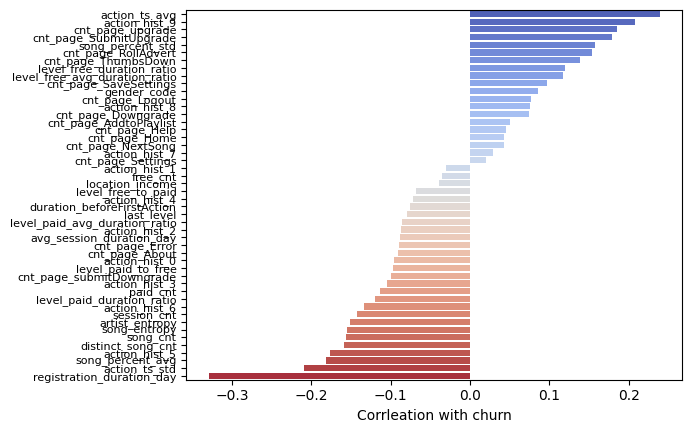

In [ ]:
fig,ax = plt.subplots(1,1)
temp_data = corr_mat_pd['churn'].reset_index().query('index!="churn"').sort_values('churn',ascending=False)
sns.barplot(data=temp_data,y='index',x='churn',palette='coolwarm',ax=ax)
ax.set_yticklabels(temp_data['index'],fontsize=8)
ax.set_ylabel('')
ax.set_xlabel('Corrleation with churn')
fig.show()

Now, we will conduct two-sample t-tests for churn and non-churn user groups to determine which features exhibit statistically significant differences between the two groups.

In [ ]:
from statsmodels.stats.multitest import multipletests

def ttest(df,group_feature, test_feature):
    flag0 = df[group_feature]==0
    flag1 = ~flag0
    vector_0 = df.loc[flag0,test_feature]
    vector_1 = df.loc[flag1,test_feature]
    statistic, pvalue = stats.ttest_ind(vector_1, vector_0)
    return [statistic,pvalue,test_feature]


pd_data_final = data_final.toPandas()
ttest_result = []
for c in pd_data_final.columns:
    result = ttest(pd_data_final,'churn',c)
    ttest_result.append(result)

In [ ]:
# p-value adjustment for multiple test
df_ttest_result = pd.DataFrame(ttest_result,columns=['stats','pvalue','feature'])
df_ttest_result.sort_values('pvalue')
df_ttest_result['pvalue_adjust'] = multipletests(df_ttest_result['pvalue'],method='fdr_bh')[1]

In [ ]:
candidate_feature = df_ttest_result.query('pvalue_adjust<0.05 and feature!="churn"').sort_values('stats')['feature'].to_list()
df_ttest_result.query('pvalue_adjust<0.05 and feature!="churn"')

,stats,pvalue,feature,pvalue_adjust
2,-5.199911,4.505479e-07,registration_duration_day,0.000011
18,-2.765253,6.164242e-03,song_percent_avg,0.043150
25,-2.673427,8.063338e-03,action_hist_5,0.043900
29,3.165277,1.765581e-03,action_hist_9,0.017303
30,3.677763,2.949271e-04,action_ts_avg,0.004817
31,-3.185056,1.654162e-03,action_ts_std,0.017303
44,2.821038,5.218613e-03,cnt_page_upgrade,0.042619
46,2.705654,7.343848e-03,cnt_page_SubmitUpgrade,0.043900


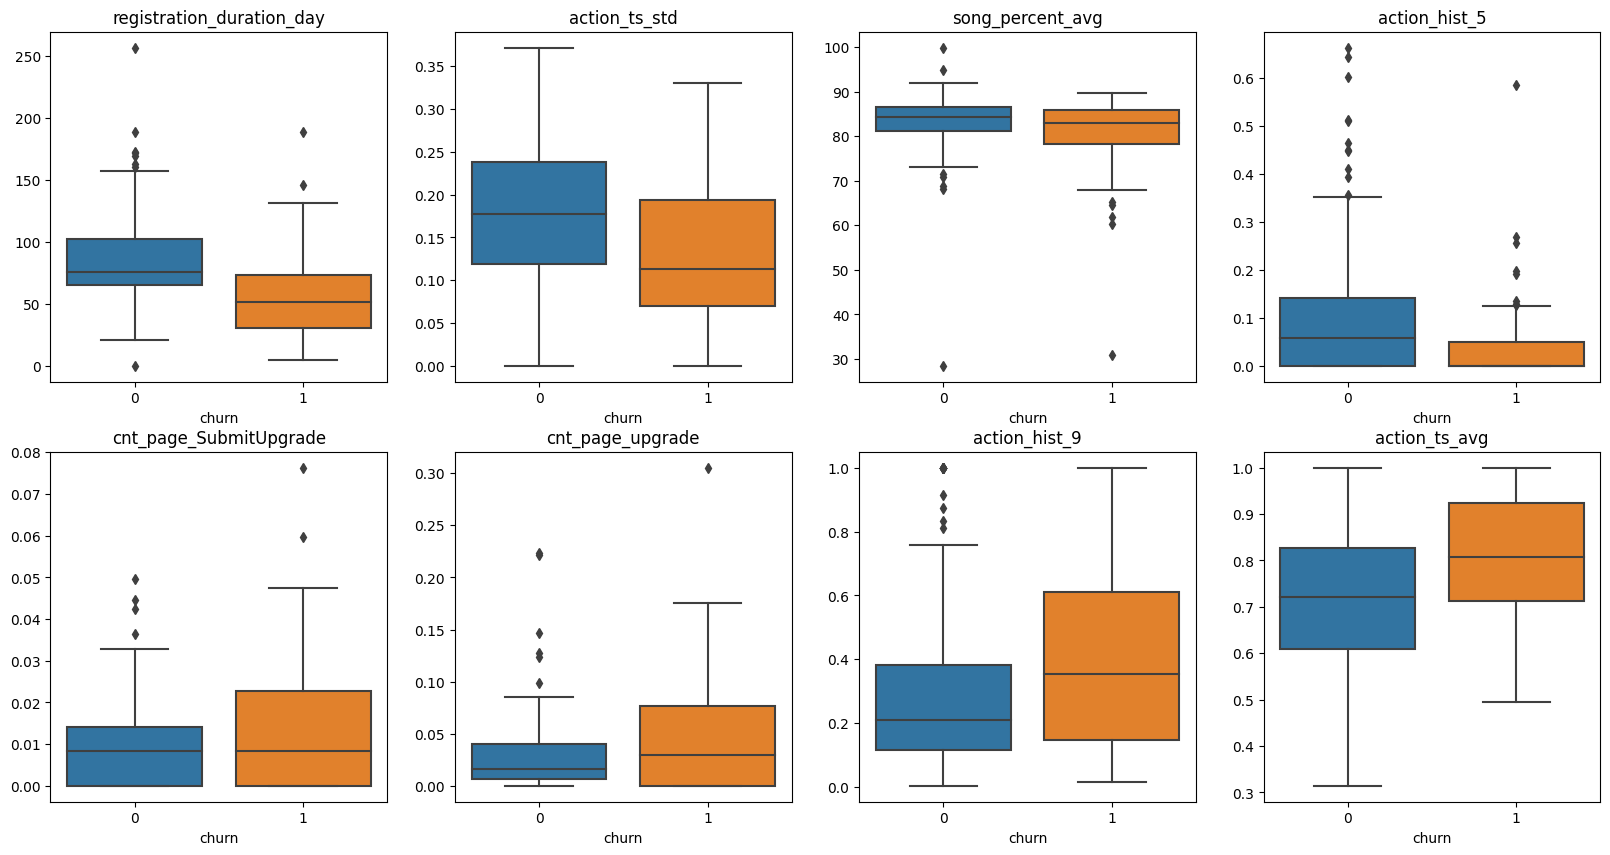

In [ ]:
fig, ax = plt.subplots(2,4,figsize=(20,10))
index = 0
for i in range(2):
    for j in range(4):
        sns.boxplot(x="churn",y=candidate_feature[index],data=pd_data_final,ax=ax[i,j])
        ax[i,j].set_title(candidate_feature[index])
        ax[i,j].set_ylabel('')
        index += 1
fig.show()

***registration_duration_day***  
The feature ***registration_duration_day*** exhibited a highly statistically significant difference (p-value_adjust = 0.000011) between churn and non-churn user groups. This suggests that users who have been registered for a longer duration are less likely to churn. If we aim to reduce the churn rate, our focus should be on new users, as they are more likely to churn within a shorter duration of registration.

***action_ts_avg***  
Regarding ***action_ts_avg*** (the average timestamp of a user's actions normalized by their lifespan), it appears that non-churning users tend to engage with the Sparkify platform earlier after registration compared to churning users.

***action_ts_std***  
***action_ts_std*** suggests that users with high variability in their usage times are less likely to churn. In essence, users who interact with the platform regularly are more likely to become loyal customers.

***action_hist_5*** and ***action_hist_9***  
Non-churn users show increased interaction in the middle of their customer lifespan, while churn users exhibit a spike just before churn. This suggests specific pre-churn activities. Further investigation into churn user activities before churn could inform mitigation strategies. The boxplot illustrates action frequency distribution across customer lifespan phases. Understanding these patterns aids in tailoring interventions for improved retention.


<Axes: xlabel='period', ylabel='action'>

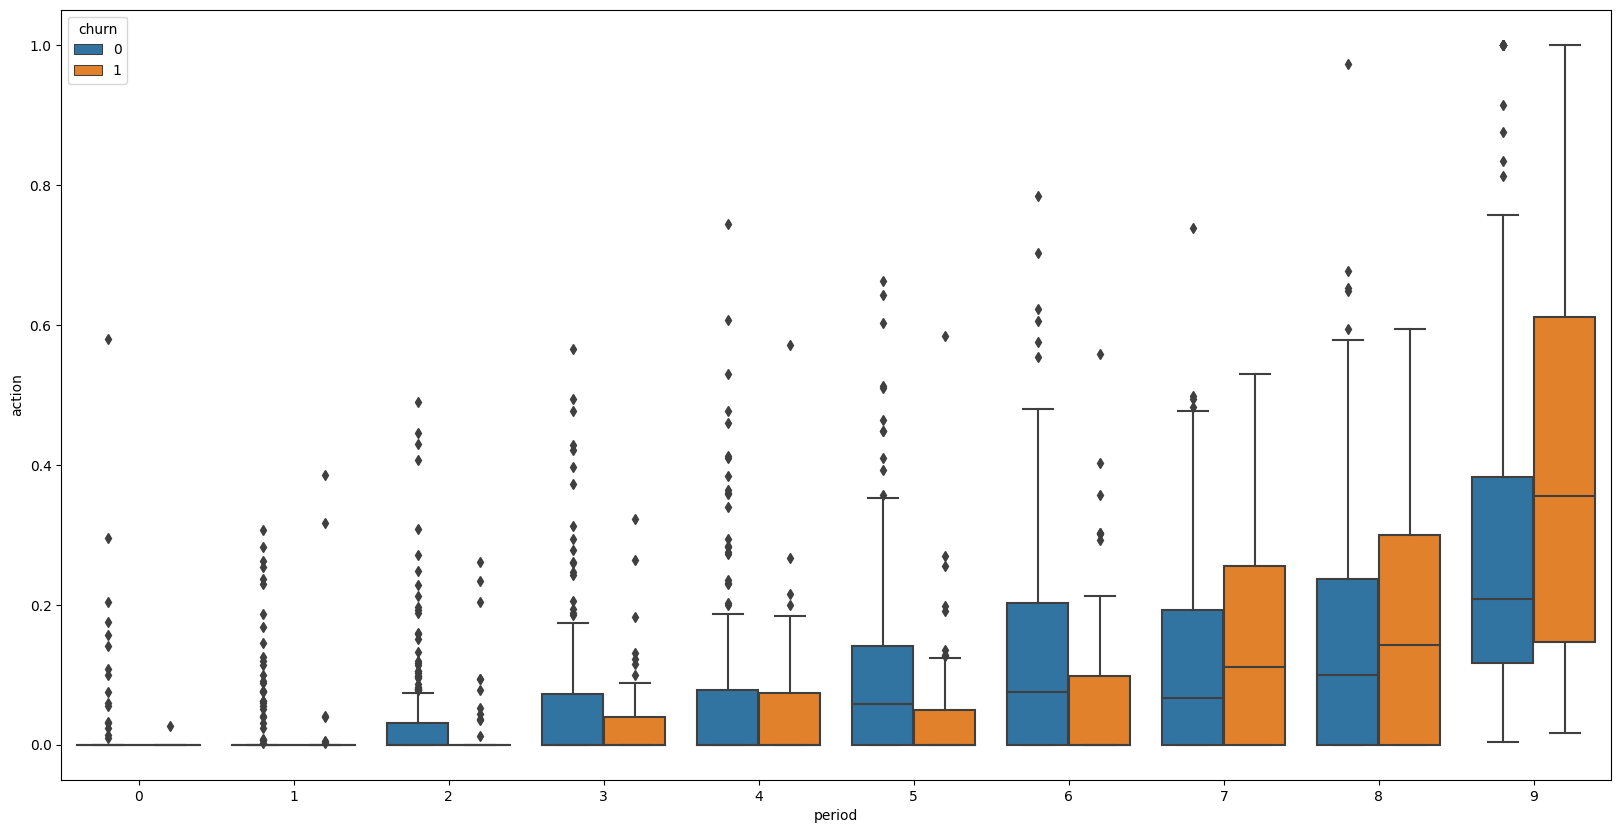

In [ ]:
pd_data_final['id'] = range(pd_data_final.shape[0])

df_action = pd.wide_to_long(pd_data_final[['id','churn','action_hist_0','action_hist_1','action_hist_2','action_hist_3','action_hist_4','action_hist_5','action_hist_6','action_hist_7','action_hist_8','action_hist_9']],
                stubnames=['action'],
                i=['id','churn'],
                j= 'period',
                sep='_hist_',
                suffix='.+'
               ).reset_index()

fig,ax = plt.subplots(1,1,figsize=(20,10))
sns.boxplot(x='period',y='action',data=df_action,hue='churn',ax=ax)

<a id="fs"></a>
### 2.2.4 Feature Selection

Our feature correlation heatmap revealed numerous features with high correlations. To mitigate collinearity, I will identify groups of closely correlated features and select only one from each group for subsequent modeling. This approach aims to streamline the feature set while preserving the most relevant information for our analysis. By reducing redundancy in correlated features, we can enhance model performance and interpretability while avoiding multicollinearity issues that may arise during modeling.


In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

# construct an adjacency matrix where high correlation (> 0.85) is labeled as 1, otherwise 0
is_high_corr = np.abs(corr_mat_pd.values) > 0.85
adj_mat = csr_matrix(is_high_corr.astype(int) - np.eye(len(data_final.columns)))

# find groups of highly correlated features by finding the connected components in the adjacency matrix
_, corr_labels = connected_components(csgraph=adj_mat, directed=False)
unique, unique_counts = np.unique(corr_labels, return_counts=True)
# get groups with size > 1
high_corr_labels = unique[unique_counts > 1]

# if there is at least one group of highly correlated features
if len(high_corr_labels) > 0:
    # map the label indices of highly correlated features to their column names
    print('Highly correlated features include:')
    high_corr_col_dict = {}
    for high_corr_label in high_corr_labels:
        high_corr_col_dict[high_corr_label] = [col_name for corr_label, col_name in zip(corr_labels, data_final.columns)
                                               if corr_label == high_corr_label]
        print(high_corr_col_dict[high_corr_label])

    print('\nFeatures to keep:')
    cols_to_drop = []
    for col_name_list in high_corr_col_dict.values():
        # keep the feature that has the highest correlation with 'Churn'
        col_to_keep = corr_mat_pd.loc[col_name_list,'churn'].idxmax()
        print(col_to_keep)
        # remove the other features to avoid multicollinearity
        col_name_list.remove(col_to_keep)
        corr_mat_pd.drop(index=col_name_list, columns=col_name_list, inplace=True)
        cols_to_drop.extend(col_name_list)

data_final = data_final.drop(*cols_to_drop)

Highly correlated features include:
['registration_duration_day', 'duration_beforeFirstAction']
['level_paid_to_free', 'cnt_page_submitDowngrade']
['level_free_avg_duration_ratio', 'level_paid_avg_duration_ratio', 'level_free_duration_ratio', 'level_paid_duration_ratio']
['song_cnt', 'distinct_song_cnt', 'session_cnt']
['song_entropy', 'artist_entropy']
['cnt_page_ThumbsDown', 'cnt_page_Home', 'cnt_page_Downgrade', 'cnt_page_Logout', 'cnt_page_AddtoPlaylist', 'cnt_page_NextSong', 'cnt_page_Help']

Features to keep:
duration_beforeFirstAction
level_paid_to_free
level_free_duration_ratio
session_cnt
artist_entropy
cnt_page_ThumbsDown


<a id="dm"></a>
# 3. Data Modeling

In [ ]:
# split the data into train, validation and test sets using stratified sampling based on 'churn'
train = data_final.sampleBy('churn', fractions={0: 0.8, 1: 0.8}, seed=42)
test = data_final.subtract(train)

# assign class weight
y_collect = train.select('churn').groupBy('churn').count().collect()
bin_counts = {y['churn']: y['count'] for y in y_collect}
total = np.sum(e for e in bin_counts.values())
n_labels = len(bin_counts)
weights = {bin_: total/(n_labels*count) for bin_, count in bin_counts.items()}
train = train.withColumn('weight', when(col('churn')==1.0, weights[1]).otherwise(weights[0]))

<a id="Hyper"></a>
##  3.1  Hyperparameter tuning


### Performance metrics
In selecting evaluation metrics, I opted for AUC-PR and F1 instead of AUC-ROC. AUC-PR specifically assesses classifier performance with emphasis on the positive class, making it particularly advantageous for imbalanced datasets, which is the case here. This choice allows for a more nuanced evaluation that prioritizes model performance in scenarios where correctly identifying positive instances, such as churn cases, is of paramount importance.

In [ ]:
assembler = VectorAssembler(inputCols=[c for c in train.columns if c not in ['churn','weight']], outputCol="NumFeatures")
scaler = MinMaxScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures")

# logistic regression
lr = LogisticRegression(featuresCol='ScaledNumFeatures', weightCol='weight', labelCol='churn')
pipeline_lr = Pipeline(stages=[assembler, scaler, lr])
paramGrid_lr = ParamGridBuilder() \
            .addGrid(lr.regParam, [0.01, 0.1,0.5],) \
            .addGrid(lr.maxIter, [10, 20,40]) \
             .build()
crossval_lr = CrossValidator(estimator = pipeline_lr,
                             estimatorParamMaps = paramGrid_lr,
                             evaluator = BinaryClassificationEvaluator(labelCol='churn', weightCol='weight',metricName='areaUnderPR'),
                             parallelism=4,
                             numFolds=4)

# random forest
rf = RandomForestClassifier(featuresCol='ScaledNumFeatures', weightCol='weight',labelCol='churn', seed=42,)
pipeline_rf = Pipeline(stages=[assembler, scaler, rf])
paramGrid_rf = ParamGridBuilder() \
              .addGrid(rf.numTrees, [50, 100, 150]) \
              .addGrid(rf.maxDepth, [10, 20]) \
              .build()
crossval_rf = CrossValidator(estimator = pipeline_rf,
                             estimatorParamMaps = paramGrid_rf,
                             evaluator = BinaryClassificationEvaluator(labelCol='churn', weightCol='weight',metricName='areaUnderPR'),
                             parallelism=4,
                             numFolds=4)

# SVM
svm = LinearSVC( featuresCol="ScaledNumFeatures",weightCol='weight',labelCol="churn")
pipeline_svm = Pipeline(stages=[assembler, scaler, svm])
paramGrid_svm = ParamGridBuilder() \
    .addGrid(svm.maxIter, [10, 100, 1000]) \
    .addGrid(svm.regParam, [0.1, 0.01]) \
    .build()
crossval_svm = CrossValidator(estimator=pipeline_svm,
                              estimatorParamMaps=paramGrid_svm,
                             evaluator = BinaryClassificationEvaluator(labelCol='churn', weightCol='weight',metricName='areaUnderPR'),
                              parallelism=4,
                              numFolds=4)

In [ ]:
def print_metrics(pred, label='churn'):
    """Print evaluation metrics on a test set

    Args:
    pred: (spark dataframe) a test set

    Returns:
    summary: (pandas dataframe) a summary of evaluation metrics
    """
    eval_metrics = {}

    # compute area under PR curve
    evaluator = BinaryClassificationEvaluator(labelCol=label)
    auc_pr = evaluator.evaluate(pred, {evaluator.metricName:'areaUnderPR'})
    # compute precision, recall and f1 score
    predictionAndLabels = pred.select('prediction', label)
    # both 'prediction' and label in predictionAndLabels need to be cast to float type and
    # map to tuple before calling 'MulticlassMetrics'
    metrics = MulticlassMetrics(predictionAndLabels.rdd.map(lambda x: tuple(map(float, x))))

    # get overall statistics
    eval_metrics['overall'] = [metrics.weightedPrecision, metrics.weightedRecall, \
                               metrics.weightedFMeasure(), auc_pr]

    # get statistics by class
    classes = [0.0, 1.0]
    for cls in classes:
        eval_metrics['class ' + str(int(cls))] = [metrics.precision(cls), metrics.recall(cls), \
                                                  metrics.fMeasure(cls), '']

    # convert to a pandas dataframe for display
    summary = pd.DataFrame.from_dict(eval_metrics, orient='index', \
                                     columns=['precision', 'recall', 'f1 score', 'AUC-PR'])

    return summary

In [ ]:
cv_lr = crossval_lr.fit(train)
test_prediction = cv_lr.transform(test)
print_metrics(test_prediction)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-13:

Traceback (most recent call last):

  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner

    self.run()

  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run

    self._target(*self._args, **self._kwargs)

  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor

    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]

  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>

    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]

KeyError: 'jobGroup'


         precision    recall  f1 score   AUC-PR

overall   0.863429  0.857143  0.859502  0.72207

class 0   0.920000  0.884615  0.901961         

class 1   0.700000  0.777778  0.736842         

/mnt/yarn/usercache/livy/appcache/application_1709394439555_0001/container_1709394439555_0001_01_000001/pyspark.zip/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.

In [ ]:
cv_rf = crossval_rf.fit(train)
test_prediction = cv_rf.transform(test)
print_metrics(test_prediction)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-14:

Traceback (most recent call last):

  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner

    self.run()

  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run

    self._target(*self._args, **self._kwargs)

  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor

    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]

  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>

    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]

KeyError: 'jobGroup'


         precision    recall  f1 score    AUC-PR

overall   0.972487  0.971429  0.970858  0.966232

class 0   0.962963  1.000000  0.981132          

class 1   1.000000  0.888889  0.941176          

/mnt/yarn/usercache/livy/appcache/application_1709394439555_0001/container_1709394439555_0001_01_000001/pyspark.zip/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.

In [ ]:
cv_svm = crossval_svm.fit(train)
test_prediction = cv_svm.transform(test)
print_metrics(test_prediction)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-15:

Traceback (most recent call last):

  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner

    self.run()

  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run

    self._target(*self._args, **self._kwargs)

  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor

    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]

  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>

    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]

KeyError: 'jobGroup'


         precision    recall  f1 score    AUC-PR

overall   0.863429  0.857143  0.859502  0.733718

class 0   0.920000  0.884615  0.901961          

class 1   0.700000  0.777778  0.736842          

/mnt/yarn/usercache/livy/appcache/application_1709394439555_0001/container_1709394439555_0001_01_000001/pyspark.zip/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.

<a id="Inter"></a>
##  3.2  Model Interpretation

![](https://github.com/zhukuixi/Udacity_DataScientistNanoDegree/blob/main/Project4_Sparkify/img/classifier_performance.png)


 Based on the overall solid performance in all metrics, we decide to use Random Forest Model classifier as the final model and examine the feature importance in this model with SHAP library.

In [ ]:

from shap import TreeExplainer
import shap

explainer = TreeExplainer(cv_rf.stages[-1])
# Convert training data into Pandas DataFrame for shap
features = [c for c in train.columns if c not in ['churn','weight']]
assembler = VectorAssembler(inputCols=features, outputCol="NumFeatures")
scaler = MinMaxScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures")
pipe_data =  Pipeline(stages=[assembler, scaler])
train_process = pipe_data.fit(train)
train_X  = train_process.transform(train)
X=train_X.select('ScaledNumFeatures').toPandas()
X['new'] = X.apply(lambda x: x['ScaledNumFeatures'].toArray(),axis=1)
data_x = pd.DataFrame(X['new'].to_list(),columns=[c for c in train.columns if c not in ['churn','weight']])

# get shap values
shap_values = explainer.shap_values(data_x, check_additivity=False)

### SHAP Feature Importance Summary Graph

### Investigating Feature Impact on Churn
Let's take a closer look at those top important features by drawing the SHAP dependence plot. THE SHAP dependence plot is a type of scatter plot that displays how a model's predictions are affected by a specific feature. 
- **Y-axis** represents the SHAP value, which indicates **the degree of change in log odds**.
- **X-axis** represents the feature's value

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-45:

Traceback (most recent call last):

  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner

    self.run()

  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run

    self._target(*self._args, **self._kwargs)

  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor

    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]

  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>

    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]

KeyError: 'jobGroup'


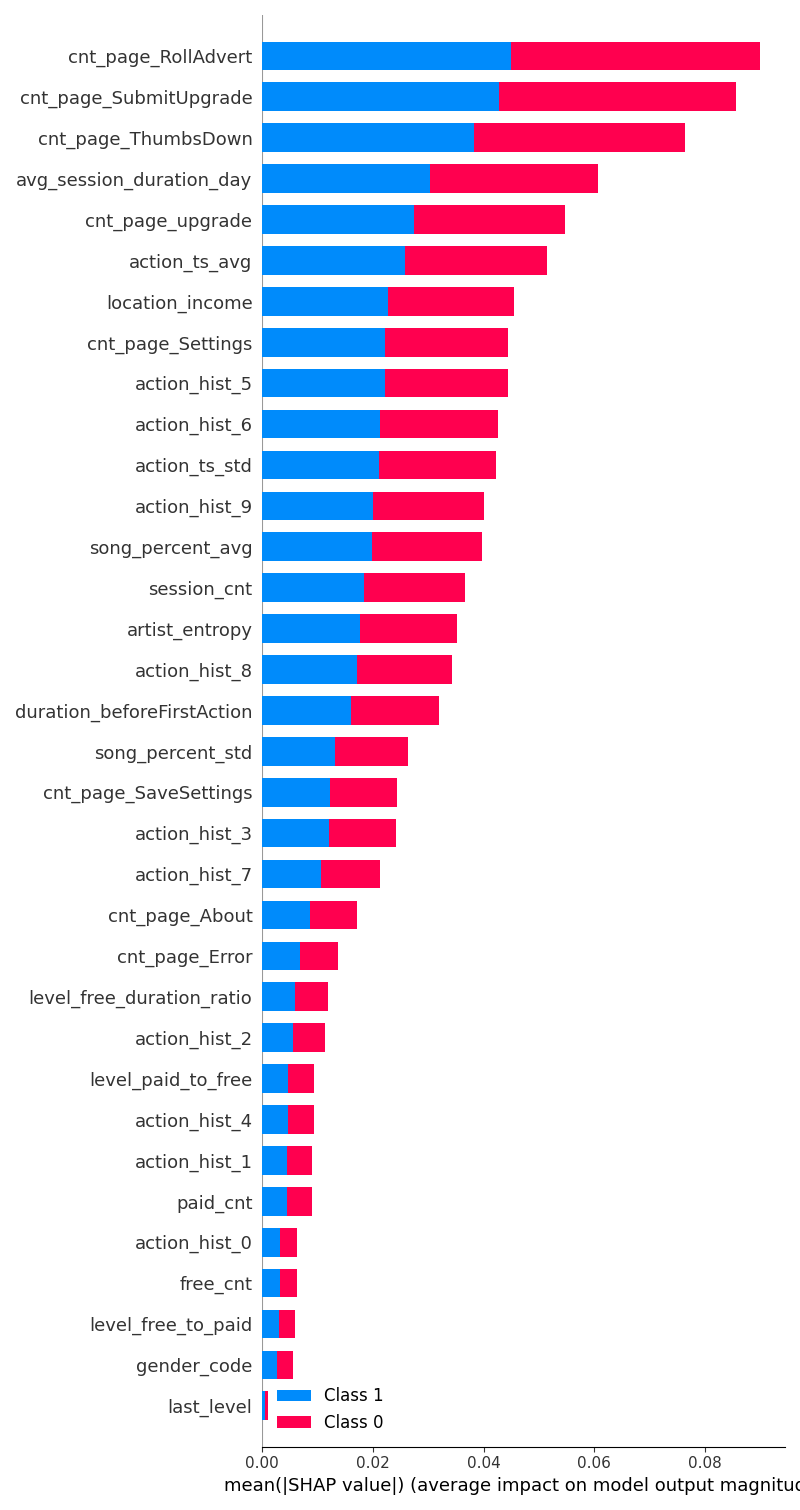

In [ ]:
# draw feature importance graph
plt.close()
shap.summary_plot(shap_values, data_x,max_display=len(features))
%matplot plt

From the graph, we see higher values in ***cnt_page_RollAdvert*** and ***cnt_page_SubmitUpgrade*** correlate with churn. However, ***gender_code***(gender) and ***last_level*** (last account status: paid/free) have minimal impact on churn likelihood.

### SHAP Summary Grpah with class label = 1 (churn)

- **Y-axis** indicates the feature names in order of importance from top to bottom.
- **X-axis** represents the SHAP value, which indicates **the degree of change in log odds**.
- The **color** of each point on the graph represents the value of the corresponding feature, with <span style="color:red"> **red** </span> indicating high values and <span style="color:blue"> **blue** </span> indicating low values.
- Each **point** represents a row of data from the original dataset.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-48:

Traceback (most recent call last):

  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner

    self.run()

  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run

    self._target(*self._args, **self._kwargs)

  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor

    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]

  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>

    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]

KeyError: 'jobGroup'


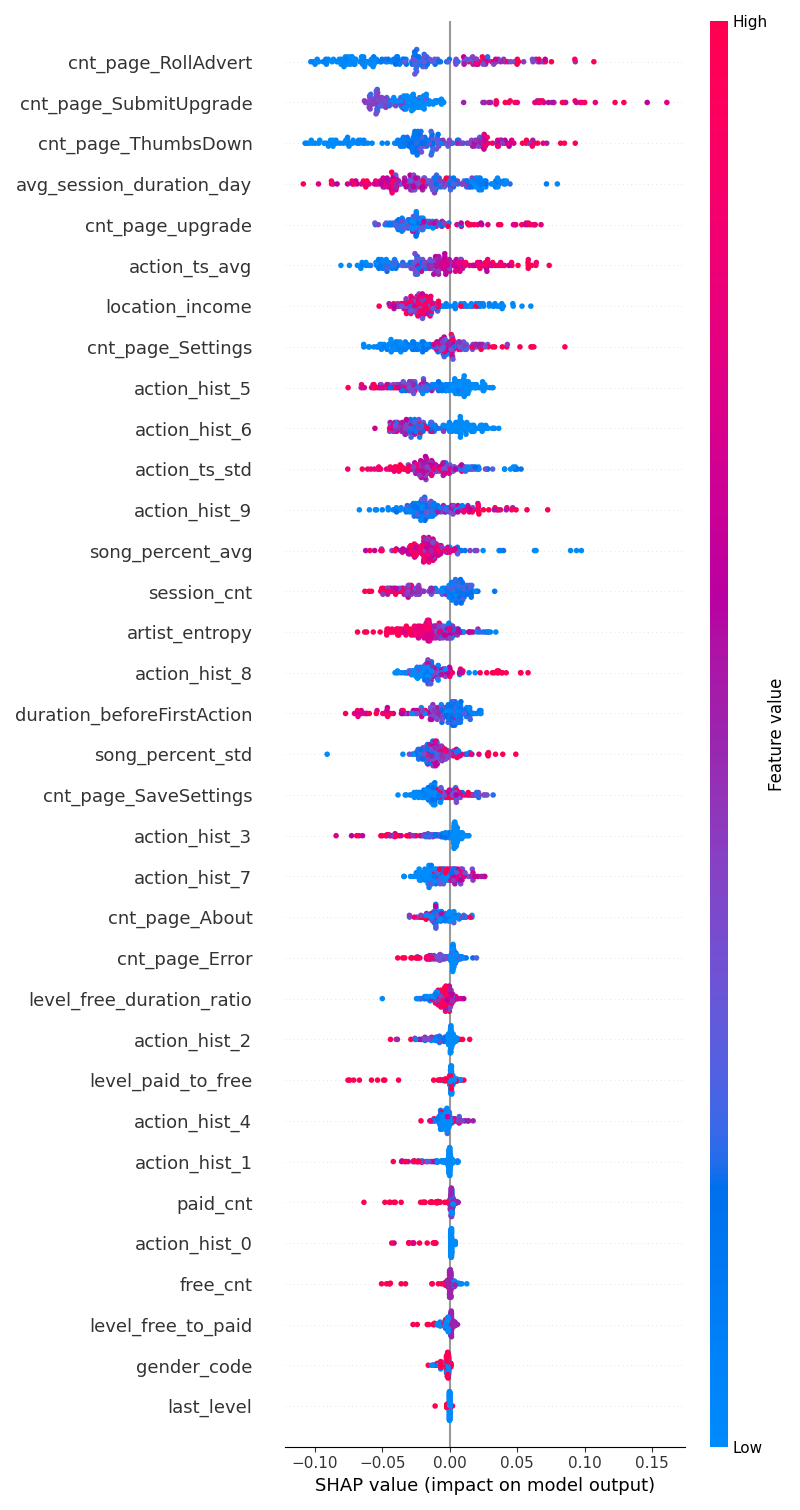

In [ ]:
plt.close()
shap.summary_plot(shap_values[1], data_x,max_display=len(features))
%matplot plt

From the graph, we see higher values in ***cnt_page_RollAdvert*** and ***cnt_page_SubmitUpgrade*** correlate with churn. However, gender_code(gender) and last_level (last account status: paid/free) have minimal impact on churn likelihood.

### Investigating Feature Impact on Churn
Let's take a closer look at those top important features by drawing the SHAP dependence plot. THE SHAP dependence plot is a type of scatter plot that displays how a model's predictions are affected by a specific feature.

- ***Y-axis*** represents the SHAP value, which indicates the degree of change in log odds.
- ***X-axis*** represents the feature's value

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-119:

Traceback (most recent call last):

  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner

    self.run()

  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run

    self._target(*self._args, **self._kwargs)

  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor

    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]

  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>

    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]

KeyError: 'jobGroup'


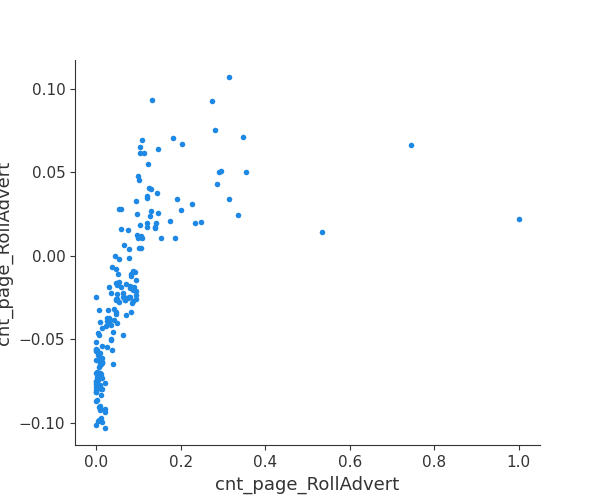

In [ ]:
plt.close()
shap.dependence_plot(
     "cnt_page_RollAdvert",
    shap_values[1],data_x,interaction_index=None
)
%matplot plt

Considering that the features have been normalized and min-max scaled, where 0.2 represents the number of roll advertisement actions divided by the user's platform lifespan (unit: day), we observe an interesting trend in the SHAP values.

The SHAP values remain negative until the ***cnt_page_RollAdvert*** value reaches **0.1**. This discovery is insightful as it suggests that until a certain threshold of advertisement interactions is reached, users are less likely to churn. This finding can inform Sparkify's advertisement strategies to target users more effectively.

Furthermore, there's potential for future work to enhance this feature by refining it to represent the number of advertisement actions divided by the number of songs listened to, providing even more informative insights into user behavior.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-143:

Traceback (most recent call last):

  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner

    self.run()

  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run

    self._target(*self._args, **self._kwargs)

  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor

    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]

  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>

    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]

KeyError: 'jobGroup'


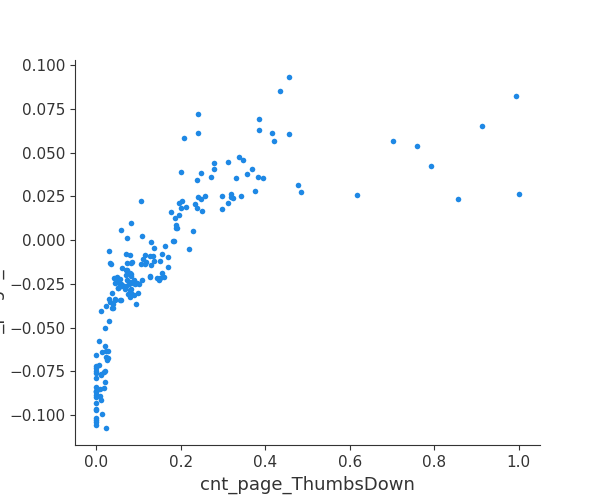

In [ ]:
plt.close()
shap.dependence_plot(
     "cnt_page_ThumbsDown",
    shap_values[1],data_x,interaction_index=None
)
%matplot plt

The SHAP values for ***cnt_page_ThumbsDown*** down increase in conjunction with the feature values, remaining negative until the thumbs down value reaches 0.2. This observation holds valuable implications for Sparkify's Recommendation System team.

The threshold of 0.2 for ***cnt_page_ThumbsDown*** could serve as a baseline error rate for the recommendation system. If a significant portion of thumbs down interactions are attributed to recommending incorrect songs to users, this threshold could help establish a benchmark for minimizing recommendation errors and improving the overall user experience.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-116:

Traceback (most recent call last):

  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner

    self.run()

  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run

    self._target(*self._args, **self._kwargs)

  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor

    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]

  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>

    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]

KeyError: 'jobGroup'


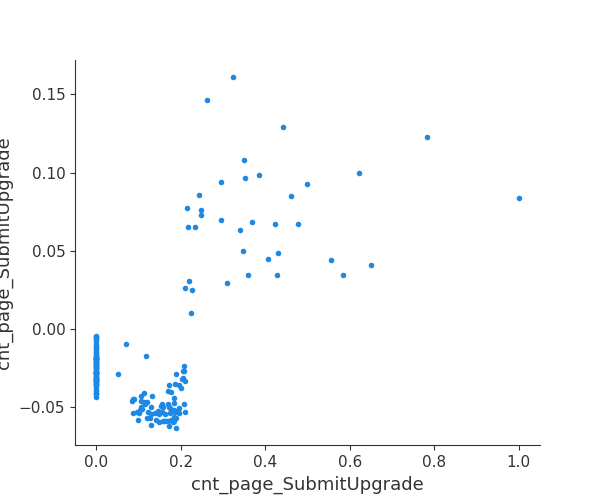

In [ ]:
plt.close()
shap.dependence_plot(
     "cnt_page_SubmitUpgrade",
    shap_values[1],data_x,interaction_index=None
)
%matplot plt

The SHAP values remain negative and gradually decrease to approximately -0.05 as ***cnt_page_SubmitUpgrade*** reaches 0.2. This trend is understandable, as loyal customers are more inclined to upgrade their accounts. However, an intriguing shift occurs when ***cnt_page_SubmitUpgrade surpasses*** 0.2, with SHAP values drastically increasing to positive territory.

This sudden change suggests that some users may repeatedly submit upgrade requests that are subsequently rejected, possibly due to issues with credit cards or other factors. This observation highlights the importance of further investigating the behavior of these users to better understand their interactions with the platform.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-149:

Traceback (most recent call last):

  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner

    self.run()

  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run

    self._target(*self._args, **self._kwargs)

  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor

    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]

  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>

    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]

KeyError: 'jobGroup'


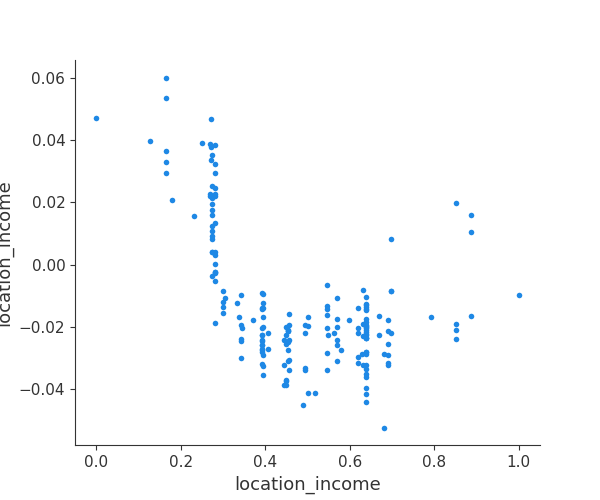

In [ ]:
plt.close()
shap.dependence_plot(
     "location_income",
    shap_values[1],data_x,interaction_index=None
)
%matplot plt


In the case of the ***location_income*** feature, the SHAP values consistently remain positive. However, an intriguing shift occurs when the ***location_income*** surpasses 0.23, with SHAP values drastically dropping below zero.

This observation warrants further investigation into the states associated with these income levels. Additionally, conducting A/B test experiments to identify the optimal subscription fee could be a strategic approach to maximize overall revenue. 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-154:

Traceback (most recent call last):

  File "/mnt/notebook-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner

    self.run()

  File "/mnt/notebook-env/lib/python3.9/threading.py", line 917, in run

    self._target(*self._args, **self._kwargs)

  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor

    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]

  File "/mnt/notebook-env/lib/python3.9/site-packages/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>

    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]

KeyError: 'jobGroup'


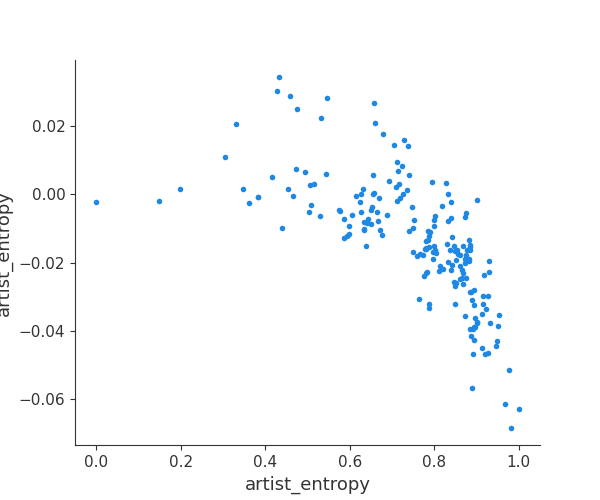

In [ ]:
plt.close()
shap.dependence_plot(
     "artist_entropy",
    shap_values[1],data_x,interaction_index=None
)
%matplot plt


The ***artist_entropy*** feature, depicting the diversity of artists a user engages with, showcases a notable trend in the SHAP values: a negative correlation.

This indicates that users who exhibit a broader scope of artists in their listening habits, as opposed to consistently favoring a select few, demonstrate lower likelihoods of churn. This insight underscores the critical role of Sparkify's recommendation system, particularly for users who predominantly engage with only one or two artists.

By enriching the user experience and promoting exploration of new music, the platform can effectively bolster customer retention and foster greater loyalty.

### SHAP Force Plot Analysis Showcase: Comparing Churn Prediction Features for Two Users

The SHAP Force Plot is a graph used to interpret the impact of individual features on model predictions for a specific sample. It provides a clear breakdown of how each feature contributes to the final prediction, allowing for a detailed understanding of the model's decision-making process. 

Below, I will present one churn user and one non-churn user, allowing us to identify the pivotal factors contributing to their respective outcomes.

For our first user, who churned, our analysis reveals that a low average song finish rate and a majority of the user's actions occurring in the late stage were the two most significant factors contributing to the churn.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

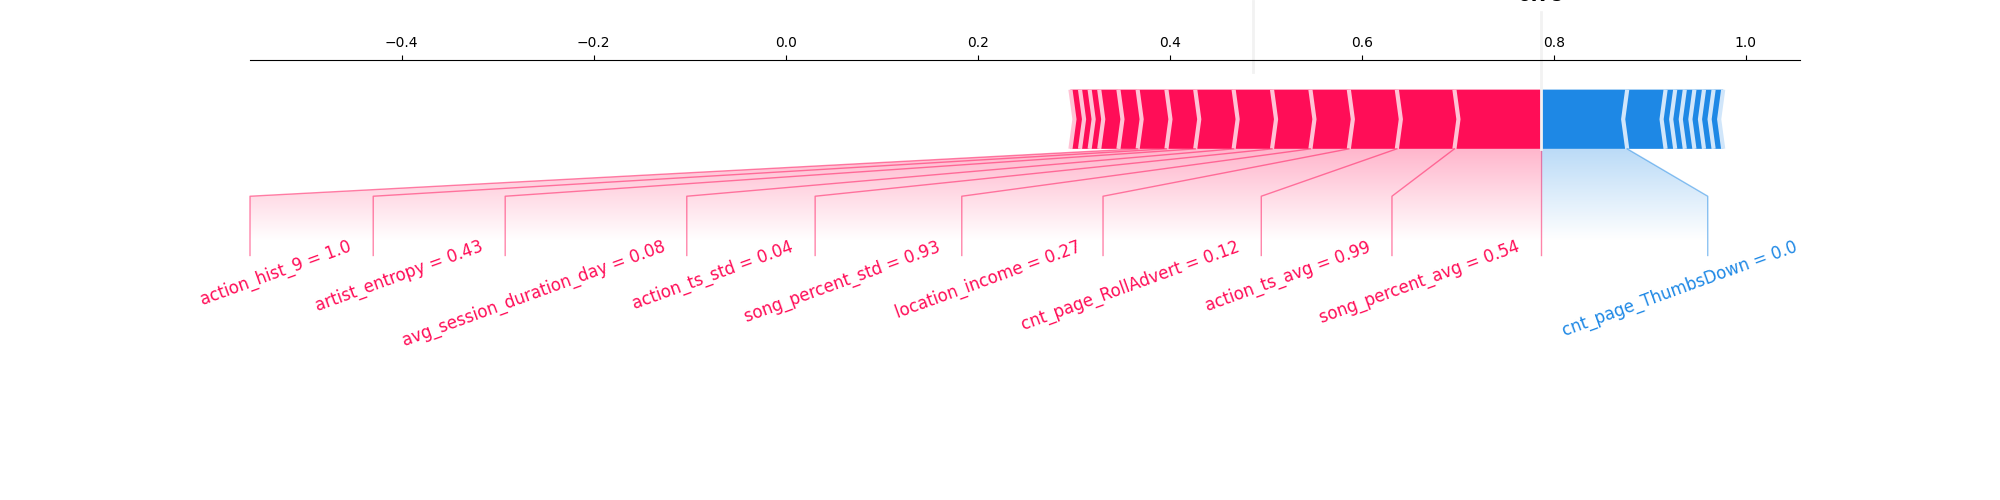

In [ ]:
plt.close()
shap.plots.force(explainer.expected_value[1], np.round(shap_values[1][3,:],2), np.round(data_x.iloc[3, :],2), matplotlib = True,text_rotation=20,figsize=(20,5))
%matplot plt

In contrast, for the second user, who did not churn, our analysis highlights the following factors: a majority of the user's actions occurring in the first 1/3 stage, an extremely low action of roll advertisement, and the user's lengthy session duration. These factors collectively contribute to the classification of the user as a non-churn user.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

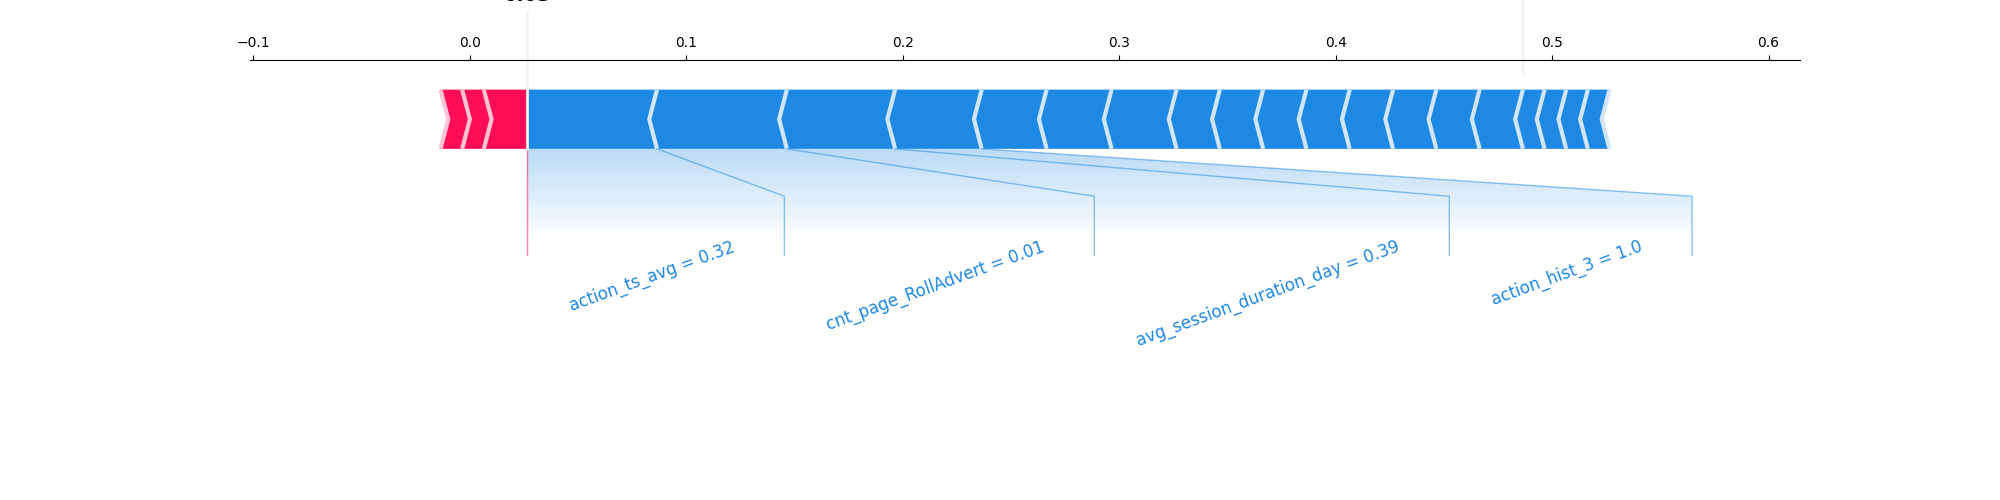

In [ ]:
plt.close()
shap.plots.force(explainer.expected_value[1], np.round(shap_values[1][0,:],2), np.round(data_x.iloc[0, :],2), matplotlib = True,text_rotation=20,figsize=(20,5))
%matplot plt

<a id="conclusion"></a>
# 4. Conclusion

Feature Impact on Churn: Factors such as average song finish rate, session duration, and engagement with roll advertisements emerged as significant predictors of churn. Users with low song finish rates and high exposure to roll advertisements were more likely to churn, while prolonged session durations correlated with reduced churn likelihood.

User Engagement Patterns: Users who engaged early, displayed diverse artist preferences, and had extended session durations were less likely to churn. Conversely, users with late-stage engagement, low diversity in artist preferences, and excessive exposure to roll advertisements were at higher risk of churn.



### Business Impact
Deploying the predictive model enables Sparkify to proactively identify potential churners among its user base. While users may choose to churn for various reasons, our model helps us pinpoint the underlying factors contributing to churn, allowing us to take targeted actions to reduce churn rates. By offering attractive perks and incentives tailored to address these reasons, Sparkify can effectively retain more users and maintain a loyal customer base.

Moreover, the analysis yields valuable business insights that inform strategic improvements:

**Optimizing Advertising and Recommendations**   
Utilizing metrics and thresholds derived from the analysis, Sparkify can fine-tune its advertising frequency and recommendation algorithms. This ensures a more tailored and engaging user experience, reducing user fatigue and increasing user satisfaction.

**Adjusting Subscription Fees**  
Insights into regional income levels allow Sparkify to adjust subscription fees accordingly. By offering flexible pricing structures that align with the economic realities of different regions, Sparkify can attract more users and improve revenue generation.

**Investigating User Behavior**   
Further investigation into churn users' frequency of page settings and upgrade requests can uncover valuable insights into user preferences and pain points. By addressing these issues through product enhancements or targeted interventions, Sparkify can enhance the overall user experience and mitigate churn risk.

In conclusion, leveraging predictive modeling and data-driven insights empowers Sparkify to proactively retain users and drive business growth. By understanding the reasons behind churn and implementing strategic improvements based on these insights, Sparkify can foster customer loyalty, increase retention rates, and achieve sustainable success in the competitive streaming market.

### Future Work
**Advanced Feature Engineering**  
Introducing more sophisticated feature engineering techniques can enhance the predictive power of the model. For instance, incorporating time-series related features such as auto-correlation can help identify patterns in user behavior, such as regular usage patterns of Sparkify.

**Early Churn Prediction**  
While our current study focuses on predicting churn using churned customer's full lifespan data, there's potential to develop models for early churn prediction. We'll focus on early churn prediction by truncating churned customer's late-stage lifespan data. This allows us to detect churn behavior earlier, enabling proactive retention strategies.
